In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')

import data_utils as du
import graph_utils as gu

from namelist import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
with h5py.File(save_dir+'BCH_MODEL_cumsum.hdf', 'r') as h5io:
    BASE_cumsum = h5io['BASE_cumsum'][:, -1, ...]
    BCNN_cumsum = h5io['BCNN_cumsum'][:, -1, ...]
    SL_cumsum = h5io['SL_cumsum'][:, -1, ...]
    SCNN_cumsum = h5io['SCNN_cumsum'][:, -1, ...]
    BCH_obs_cumsum = h5io['BCH_obs_cumsum'][:, -1, ...]

In [6]:
# three watershed groups
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
FLAGs = (flag_sw, flag_si, flag_n)

In [7]:
day = 760 # Feb 1, 2019

DATA = {}
DATA['base'] = BASE_cumsum[day, :, FLAGs[1]].flatten()
DATA['sl'] = SL_cumsum[day, :, FLAGs[1]].flatten()
DATA['scnn'] = SCNN_cumsum[day, :, FLAGs[1]].flatten()
DATA['obs'] = BCH_obs_cumsum[(day-3):(day+4), FLAGs[1]].flatten()

In [8]:
KW = {}
KW['base'] = {'linestyle': '-', 'color': orange, 'linewidth':2.5, 'edgecolor':'k', 'density':True, 'log':True}
KW['bcnn'] = {'linestyle': '-', 'color': red, 'linewidth':2.5, 'edgecolor':'k', 'density':True, 'log':True}
KW['sl'] = {'linestyle': '-', 'color': cyan, 'linewidth':2.5, 'edgecolor':'k', 'density':True, 'log':True}
KW['scnn'] = {'linestyle': '-', 'color': blue, 'linewidth':2.5, 'edgecolor':'k', 'density':True, 'log':True}
KW['obs'] = {'linestyle': '-', 'color': '0.75', 'linewidth':2.5, 'edgecolor':'k', 'density':True, 'log':True}

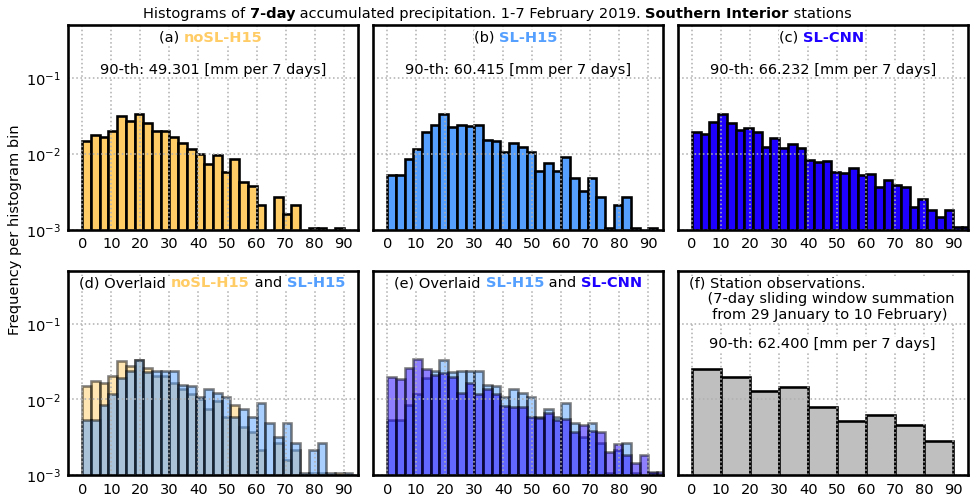

In [9]:
hist_bins = np.arange(0, 100, 3)
hist_bins_obs = np.arange(0, 100, 10)

fig = plt.figure(figsize=(12, 6), dpi=dpi_)
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1])
ax13 = plt.subplot(gs[0, 2])
ax21 = plt.subplot(gs[1, 0])
ax22 = plt.subplot(gs[1, 1])
ax23 = plt.subplot(gs[1, 2])

AX1 = [ax11, ax12, ax13]
AX2 = [ax21, ax22, ax23]
plt.subplots_adjust(0, 0, 1, 1, hspace=0.2, wspace=0.05)

x_start1 = 0.315
x_start2 = 0.35
x_start3 = 0.04
x_start4 = 0.075
y_start = 0.975

handles = []

ax_t1 = fig.add_axes([0.5*(3-2.5)/3, 1.0, 2.5/3, 0.04])
ax_t1.set_axis_off()
handles += gu.string_partial_format(fig, ax_t1, 0, 1.0, 'left', 'top', 
                                    ['Histograms of ', '7-day', ' accumulated precipitation. 1-7 February 2019. ',
                                     'Southern Interior', ' stations'], 
                                    ['k',]*5, [14,]*5,  ['normal', 'bold', 'normal', 'bold', 'normal'])

handles += gu.string_partial_format(fig, ax11, x_start1, y_start, 'left', 'top', 
                                    ['(a) ', 'noSL-H15'], ['k', orange], [14,]*2,  ['normal', 'bold'])
handles += gu.string_partial_format(fig, ax12, x_start2, y_start, 'left', 'top', 
                                    ['(b) ', 'SL-H15'], ['k', cyan], [14,]*2,  ['normal', 'bold'])
handles += gu.string_partial_format(fig, ax13, x_start2, y_start, 'left', 'top', 
                                    ['(c) ', 'SL-CNN'], ['k', blue], [14,]*2,  ['normal', 'bold'])

handles += gu.string_partial_format(fig, ax21, x_start3, y_start, 'left', 'top', 
                                    ['(d) Overlaid ', 'noSL-H15', ' and ', 'SL-H15'], ['k', orange, 'k', cyan], 
                                    [14,]*4,  ['normal', 'bold', 'normal', 'bold'])

handles += gu.string_partial_format(fig, ax22, x_start4, y_start, 'left', 'top', 
                                    ['(e) Overlaid ', 'SL-H15', ' and ', 'SL-CNN'], ['k', cyan, 'k', blue], 
                                    [14,]*4,  ['normal', 'bold', 'normal', 'bold'])

handles.append(ax23.text(0.04, y_start, 
            '(f) Station observations.\n    (7-day sliding window summation\n     from 29 January to 10 February)',
            fontsize=14, ha='left', va='top', transform=ax23.transAxes))


for ax in AX1+AX2:
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':', linewidth=1.5)
    ax.set_yticks([1e-3, 1e-2, 1e-1])
    ax.set_ylim([1e-3, 5e-1])
    ax.set_xticks(hist_bins_obs)
    ax.set_xlim([-5, 95])
    ax.tick_params(labelbottom=True)

ax11.tick_params(labelleft=True)
ax21.tick_params(labelleft=True)
ax11.set_ylabel('Frequency per histogram bin', y=0, fontsize=14)

for i, key in enumerate(['base', 'sl', 'scnn']):
    temp = DATA[key]
    temp = temp[~np.isnan(DATA[key])]
    AX1[i].hist(temp, bins=hist_bins, **KW[key]);
    handles.append(AX1[i].text(0.5, 0.815, '90-th: {:.3f} [mm per 7 days]'.format(np.percentile(temp, 90)), 
                   va='top', ha='center', fontsize=14, transform=AX1[i].transAxes))

AX2[0].hist(DATA['base'], bins=hist_bins, **KW['base'], alpha=0.5);
AX2[0].hist(DATA['sl'], bins=hist_bins, **KW['sl'], alpha=0.5);

AX2[1].hist(DATA['sl'], bins=hist_bins, **KW['sl'], alpha=0.5);
AX2[1].hist(DATA['scnn'], bins=hist_bins, **KW['scnn'], alpha=0.5);

temp = DATA['obs']
temp = temp[~np.isnan(DATA['obs'])]
AX2[2].hist(temp, bins=hist_bins_obs, **KW['obs']);
handles.append(AX2[2].text(0.5, 0.675, '90-th: {:.3f} [mm per 7 days]'.format(np.percentile(temp, 90)), 
                   va='top', ha='center', fontsize=14, transform=AX2[2].transAxes))
    
for handle in handles:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none', zorder=6))
    
if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_accum_hist.png', format='png', **fig_keys)